In [1]:
# Installing the libraries

!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.8 MB/s eta 0:00:00


In [2]:
from torch_geometric.datasets import Planetoid, WikiCS
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

#dataset = WikiCS(root='data/')

print()
print(f'Datasets: {dataset}:')
print('------------------------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'number of classes: {dataset.num_classes}')

data=dataset[0] #Get the first graph obj

print()
print(data)
print('----------------------------------')

#Statistics abt graph
print(f'number of nodes: {data.num_nodes}')
print(f'number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges/data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Datasets: Cora():
------------------------------------
Number of graphs: 1
Number of features: 1433
number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
----------------------------------
number of nodes: 2708
number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [3]:
# Importing libraries

import math
import random
import numpy as np
import torch

unseen_num = 1
k = 10 # set k closest embeddings

In [4]:
# Differentiate seen and unseen labels

original_num_classes = torch.max(data.y) + 1

all_labels = list(range(original_num_classes))
print(all_labels)

seen_labels = list(range(original_num_classes - unseen_num))
print(seen_labels)

unseen_labels = list(set(np.unique(data.y)).difference(set(seen_labels)))
unseen_labels

[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5]


[6]

In [5]:
# Setting train, validation and test node percentage

train_percentage = 0.70
validation_percentage = 0.20
test_percentage = 0.10

In [6]:
# Seperate seen and unseen nodes in different lists

seen_nodes = []
unseen_nodes = []

for i in range(data.num_nodes):
  if data.y[i] in seen_labels:
    seen_nodes.append(i)
  else:
    unseen_nodes.append(i)

In [7]:
# Total number of training, validation and testing nodes

num_train_nodes = int(len(seen_nodes) * train_percentage)
num_validation_nodes = int(len(seen_nodes) * validation_percentage)
num_test_nodes = int(len(seen_nodes) * test_percentage)

print(num_train_nodes)
print(num_validation_nodes)
print(num_test_nodes)

1769
505
252


In [8]:
# Setting up the nodes ids

training_nodes_idx = random.sample(seen_nodes, num_train_nodes)
remaining_idx = list(set(seen_nodes).difference(set(training_nodes_idx)))
validation_nodes_idx = random.sample(remaining_idx, num_validation_nodes)
add_in_test = list(set(remaining_idx).difference(set(validation_nodes_idx)))
testing_nodes_idx = unseen_nodes + add_in_test

In [9]:
# Marking the ground-truth labels as -1

import copy

ground_truth = copy.copy(np.array(data.y))

for i in range(len(ground_truth)):
    if ground_truth[i] in unseen_labels:
        ground_truth[i] = -1

In [10]:
# Setting up the train, val and test mask

tr_mask = []
val_mask = []
te_mask = []

for i in range(data.num_nodes):
    if i in training_nodes_idx:
        tr_mask.append(True)
    else:
        tr_mask.append(False)

    if i in validation_nodes_idx:
        val_mask.append(True)
    else:
        val_mask.append(False)

    if i in testing_nodes_idx:
        te_mask.append(True)
    else:
        te_mask.append(False)

In [11]:
# Setting up the dataset

from torch_geometric.data import Data
import torch

dataset_cora = Data(
    x = data.x,
    edge_index = data.edge_index,
    y = data.y,
    y_n = torch.tensor(ground_truth),
    train_mask = tr_mask,
    validation_mask = val_mask,
    test_mask = te_mask,
    num_classes = len(seen_labels)
)

In [12]:
dataset_cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], y_n=[2708], train_mask=[2708], validation_mask=[2708], test_mask=[2708], num_classes=6)

In [13]:
# GCN class

from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.conv1 = GCNConv(dataset_cora.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset_cora.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    embeddings = self.conv2(x, edge_index)
    out = F.log_softmax(embeddings, dim=1)

    return out, embeddings

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 6)
)


In [14]:
# Accuracy Function

def acc(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [15]:
# GCN Training

model = GCN(hidden_channels=256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data_set):
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out, train_embeddings = model(data_set.x, data_set.edge_index)  # Perform a single forward pass and get embeddings
    loss = criterion(out[data_set.train_mask], data_set.y_n[data_set.train_mask])
    acc_train = acc(out[data_set.train_mask], data_set.y_n[data_set.train_mask])
    loss.backward()  # Derive gradients
    optimizer.step()  # Update parameters based on gradients

    loss_val = criterion(out[data_set.validation_mask], data_set.y_n[data_set.validation_mask])
    acc_val = acc(out[data_set.validation_mask], data_set.y_n[data_set.validation_mask])

    return loss, loss_val, acc_train, acc_val, train_embeddings  # Return loss and embeddings

for epoch in range(1, 201):
    loss, val_loss, acc_train, acc_val, train_embeddings = train(dataset_cora)
    print(f'Epoch: {epoch:03d}, Train-Loss: {loss:.4f}, Train-ACC: {acc_train:.4f}, Val-Loss: {val_loss:.4f}, Val-ACC: {acc_val:.4f}')


Epoch: 001, Train-Loss: 1.7914, Train-ACC: 0.1690, Val-Loss: 1.7913, Val-ACC: 0.1683
Epoch: 002, Train-Loss: 1.7553, Train-ACC: 0.3188, Val-Loss: 1.7536, Val-ACC: 0.3267
Epoch: 003, Train-Loss: 1.7160, Train-ACC: 0.3188, Val-Loss: 1.7141, Val-ACC: 0.3267
Epoch: 004, Train-Loss: 1.6750, Train-ACC: 0.3188, Val-Loss: 1.6726, Val-ACC: 0.3267
Epoch: 005, Train-Loss: 1.6436, Train-ACC: 0.3188, Val-Loss: 1.6436, Val-ACC: 0.3267
Epoch: 006, Train-Loss: 1.6168, Train-ACC: 0.3188, Val-Loss: 1.6175, Val-ACC: 0.3267
Epoch: 007, Train-Loss: 1.5948, Train-ACC: 0.3188, Val-Loss: 1.5942, Val-ACC: 0.3267
Epoch: 008, Train-Loss: 1.5636, Train-ACC: 0.3188, Val-Loss: 1.5640, Val-ACC: 0.3267
Epoch: 009, Train-Loss: 1.5284, Train-ACC: 0.3211, Val-Loss: 1.5320, Val-ACC: 0.3307
Epoch: 010, Train-Loss: 1.4918, Train-ACC: 0.3369, Val-Loss: 1.5030, Val-ACC: 0.3386
Epoch: 011, Train-Loss: 1.4587, Train-ACC: 0.4138, Val-Loss: 1.4700, Val-ACC: 0.4040
Epoch: 012, Train-Loss: 1.4265, Train-ACC: 0.4845, Val-Loss: 1.44

In [16]:
# Converting to torch tensor

training_nodes_idx = torch.tensor(training_nodes_idx)
testing_nodes_idx = torch.tensor(testing_nodes_idx)

In [17]:
# Evaluating on test

import torch.nn.functional as F

def test():
  model.eval()
  with torch.no_grad():
    out, test_embeddings = model(dataset_cora.x, dataset_cora.edge_index)
    acc_test = acc(out[dataset_cora.test_mask], dataset_cora.y_n[dataset_cora.test_mask])

  return acc_test, test_embeddings

In [18]:
test_acc, test_emb = test()
print(f'Test Accuracy: {test_acc:.4f}')
print(test_emb.shape)

Test Accuracy: 0.5253
torch.Size([2708, 6])


In [19]:
# Test indices for sanity check

test_indices = np.array(torch.where(torch.tensor(dataset_cora.test_mask))[0])

In [20]:
# Combining each class embedding in dict

class_embedding = {key: [] for key in seen_labels}
print(class_embedding)

for i in range(len(training_nodes_idx)):
    class_embedding[dataset_cora.y[training_nodes_idx][i].item()].append(train_embeddings[training_nodes_idx[i]].tolist())

{0: [], 1: [], 2: [], 3: [], 4: [], 5: []}


In [21]:
# Converting to torch tensor

for i in range(len(class_embedding)):
    class_embedding[i] = torch.tensor(class_embedding[i])

In [22]:
# Putting the embeddings in new list

tr_embedding = []

for i in range(len(class_embedding)):
    tr_embedding.append(torch.tensor(class_embedding[i]))

<ipython-input-22-c2940137d002>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr_embedding.append(torch.tensor(class_embedding[i]))


In [23]:
# Putting in test embedding in torch tensor form

te_emb = torch.tensor(test_emb[dataset_cora.test_mask])

<ipython-input-23-45cf4212a5af>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  te_emb = torch.tensor(test_emb[dataset_cora.test_mask])


In [24]:
# https://github.com/LincLabUCCS/Open-set-text-classification-using-neural-networks
# https://github.com/vinodinimv/Openset

import scipy.spatial.distance as ssd

def normalize(vector):
    norm = np.linalg.norm(vector)
    return vector/norm if norm != 0 else vector


def md(u, v, avs):
    return ssd.mahalanobis(u, v, VI=np.linalg.inv(np.cov(avs, rowvar=False)))


def distance_metric(a, b, dist_type, cov_inp, normalized=True):
    if normalized is True:
        a = normalize(a)
        b = normalize(b)
    if dist_type == "md":
        return md(a, b, cov_inp)
    else:
        print ("Error, Invalid distance metric.")
        return None

In [25]:
import numpy as np

seen_class_AV_MAV = {}
seen_closest_AV = {}
seen_distances_AV_kClosest = {}

#k = 10

metric_type = "md"
normalized = True
for c in seen_labels:
    class_activations = np.array(tr_embedding[c])
    mean_AV = np.mean(class_activations, axis=0)

    distances_AV_MAV = []
    for AV in class_activations:
        temp_dist = distance_metric(AV, mean_AV, metric_type, class_activations, normalized=normalized) #MD
        distances_AV_MAV.append(temp_dist)
    seen_class_AV_MAV[c] = distances_AV_MAV

    closest_AVs = []
    for i in range(k):
        closest_AVs.append(class_activations[distances_AV_MAV.index(sorted(distances_AV_MAV)[i])])
    seen_closest_AV[c] = np.array(closest_AVs)

    distances_AV_kClosest = []
    for AV in class_activations:
        k_dist_temp = []
        for cAV in closest_AVs:
            temp_dist = distance_metric(AV, cAV, metric_type, class_activations, normalized=normalized)
            k_dist_temp.append(temp_dist)
        distances_AV_kClosest.append(np.mean(k_dist_temp))
    seen_distances_AV_kClosest[c] = np.array(distances_AV_kClosest)

In [26]:
#!pip install libmr

  Preparing metadata (setup.py) ... done
  Created wheel for libmr: filename=libmr-0.1.9-cp310-cp310-linux_x86_64.whl size=549043 sha256=cf17e32059fa296ff830215429d5ac28a2e0c55b2930d0fe01afab120364f7b9
  Stored in directory: /root/.cache/pip/wheels/8a/e0/45/ec5f4f802b034150d6f5735922408cc0278bf85582b2a1a954
Successfully built libmr


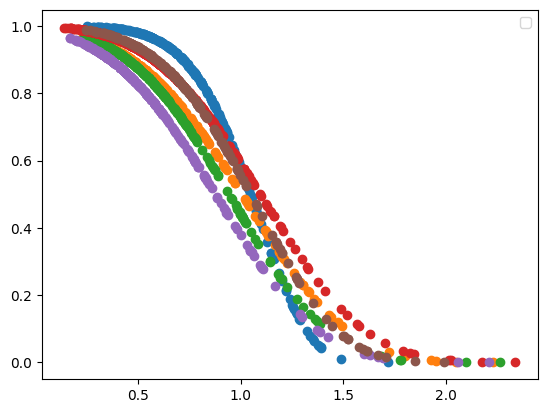

Done generating Mahalanobis Model, tailsize: 90


In [30]:
import libmr
import matplotlib.pyplot as plt
import pickle

tail_size = 90


for c in range(len(seen_labels)):
    mr = libmr.MR()
    distance = seen_distances_AV_kClosest[c] #np.array(distances[c], dtype=np.double)
    mr.fit_high(distance, tail_size)
    plt.scatter(np.array(distance), 1-mr.w_score_vector(distance))
    pickle.dump(mr.as_binary(), open('/content/drive/MyDrive/Applied____AI/'+str(c)+".npy", "wb"))

plt.legend()
plt.show()
print("Done generating Mahalanobis Model, tailsize: "+str(tail_size))

In [31]:
import tqdm

metric_type = "md" #
normalized = True
threshold = 0.8

md_pred = []
max_csps = []
max_osps = []
os_probs = []
weibull_models = {}
trained_class_avs = {}
closest_avs = {}

for tc in seen_labels:
    weibull_models[tc] = libmr.load_from_binary(pickle.load(open('/content/drive/MyDrive/Applied____AI/'+str(tc)+".npy", "rb")))
    trained_class_avs[tc] = tr_embedding[tc]
    closest_avs[tc] = seen_closest_AV[tc]


#mr = libmr.MR()



for av in test_emb[dataset_cora.test_mask]:
    d = {}
    p = {}
    for tc in seen_labels:
        k_dist_temp = []
        for e in closest_avs[tc]:
            cov_inp = trained_class_avs[tc]
            temp_dist = distance_metric(av, e, metric_type, cov_inp, normalized=normalized)
            k_dist_temp.append(temp_dist)
        d[tc] = np.mean(k_dist_temp)
        p[tc] = 1-weibull_models[tc].w_score_vector(np.array([d[tc]], dtype="double"))
    av_os_prob = list(p.values())
    total_csp = np.sum(av_os_prob, axis=0)
    osp = 1-total_csp
    max_csp = p[max(p, key=p.get)][0]
    if float(max_csp) < float(osp) or float(max_csp) < threshold:
        md_pred.append(-1)
    else:
        md_pred.append(max(p, key=p.get))
print ("Done.")

Done.


In [32]:
true = dataset_cora.y_n[dataset_cora.test_mask]
pred = torch.tensor(md_pred)

In [33]:
correct_predictions = (pred == true).sum().item()
total_predictions = len(true)
accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 75.12%


In [34]:
un_node = []
k_node = []

for i in testing_nodes_idx:
    if i in unseen_nodes:
      un_node.append(True)
    else:
      un_node.append(False)

    if i in add_in_test:
      k_node.append(True)
    else:
      k_node.append(False)

In [35]:
gt = dataset_cora.y_n[dataset_cora.test_mask]
print("Total Unknown Nodes : ", len(gt[un_node]))
print("Total Known Nodes : ", len(gt[k_node]))

Total Unknown Nodes :  180
Total Known Nodes :  254


In [36]:
pd_un = pred[un_node]
print("Predictions Unknown: ", len(pd_un))

Predictions Unknown:  180


In [37]:
correct_predictions = (gt[un_node] == pd_un).sum().item()
print(correct_predictions)
total_predictions = len(gt[un_node])
accuracy = correct_predictions / total_predictions

print(f"Accuracy Unknown : {accuracy * 100:.2f}%")

132
Accuracy Unknown : 73.33%


In [38]:
pd_k = pred[k_node]
print("Predictions Known: ", len(pd_k))

Predictions Known:  254


In [39]:
correct_predictions = (gt[k_node] == pd_k).sum().item()
print(correct_predictions)
total_predictions = len(gt[k_node])
accuracy = correct_predictions / total_predictions

print(f"Accuracy Known : {accuracy * 100:.2f}%")

194
Accuracy Known : 76.38%
